In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchsummary


from trainer import Trainer 
from tester import Tester
from utils import  visualize_data,show_misclassified_images,plot_class_distribution,plot_confusion_matrix,plot_curves,denormalize
from dataloader import Cifar10DataLoader,Cifar10Dataset
from vistransformers import train_transforms,test_transforms,cutout_transforms

In [3]:
torch.cuda.amp.autocast(enabled=True,dtype=torch.float16)
torch.set_float32_matmul_precision('medium')

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Is CUDA available? ", use_cuda)

Is CUDA available?  True


In [4]:
# CIFAR10 Data
train_data = Cifar10Dataset(root='../../data',train=True,download=False,transform=cutout_transforms)
test_data = Cifar10Dataset(root='../../data',train=False,download=False,transform=test_transforms)

# CIFAR10 DataLoader
loader = Cifar10DataLoader(batch_size=32,is_cuda_available=True)
train_loader = loader.get_loader(train_data,train=True)
test_loader  = loader.get_loader(test_data,train=False)

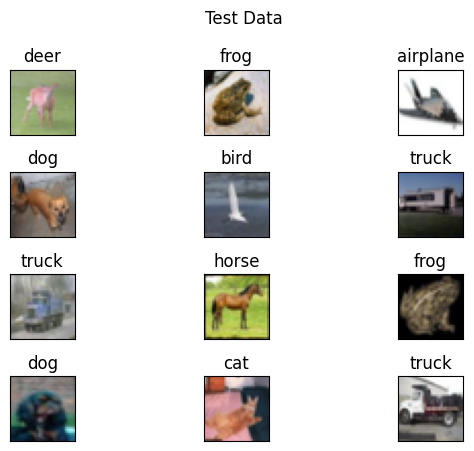

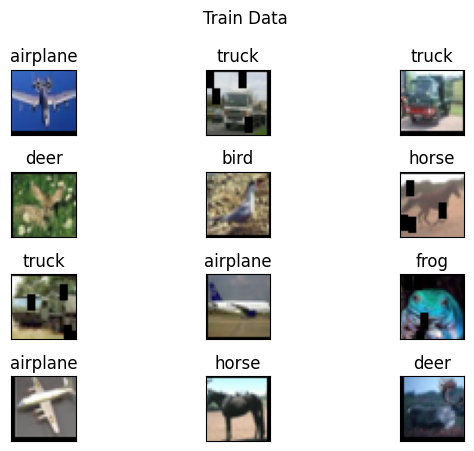

In [5]:
visualize_data(test_loader,12,"Test Data",classes=test_data.classes);
visualize_data(train_loader,12,"Train Data",classes=train_data.classes);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


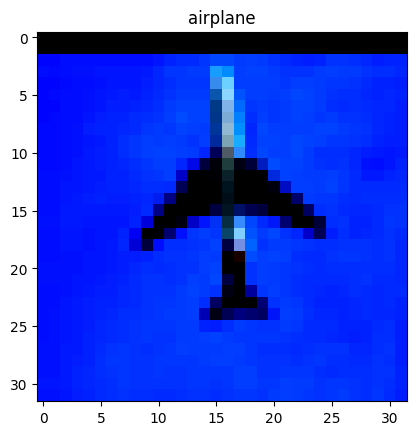

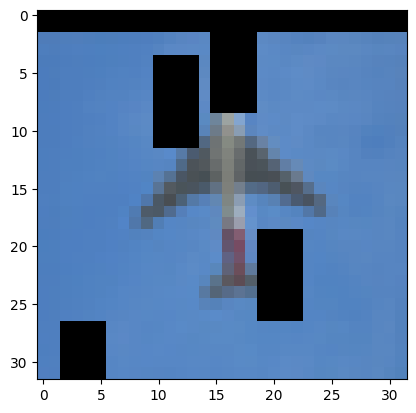

In [16]:
from matplotlib import pyplot as plt
I = 1243
plt.imshow(train_loader.dataset[I][0].permute(1,2,0).numpy())
plt.title(train_data.classes[train_loader.dataset[I][1]])
plt.show()

plt.imshow(denormalize(train_loader.dataset[I][0].numpy()))
plt.show()

In [ ]:
# optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
# criterion = nn.NLLLoss()


# trainer = Trainer(model, train_loader, optimizer, criterion, device)
# tester = Tester(model, test_loader, criterion, device)

# for epoch in range(1, 21):
#     trainer.train(epoch=epoch)
#     _,test_loss = tester.test()
#     scheduler.step(test_loss)
#     print('-'*200)


# misclassified_images, predictions, labels = tester.get_misclassified_images()

# show_misclassified_images(
#     misclassified_images[:20],
#     predictions[:20],
#     labels[:20],
#     cifar10.classes,
# );

# plot_confusion_matrix(model,train_loader,'cuda',train_loader.dataset.classes);

# plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies);